In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# 1. Read the CSV file
file_path = "C:/Users/piyalong/Downloads/harvey_observed_waterDepth.csv"
all_df = pd.read_csv(file_path)

# Print column info
print("Number of variables:", len(all_df.columns))
print("Variables:", all_df.columns.tolist())

# 2. Select numeric columns for features
numeric_cols = all_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

features = [
    # 'INTPTLAT', 
    # 'INTPTLON',
    "Harvey_Totals",
    "harvey_Wind",
    "harvey_TMax",
    "harvey_TMin",
    "harvey_Pre",
    "harvey_CERA",
    "Elevation",
    "waterDepth"
]


df=all_df[features]
# Define target (e.g., predict Harvey_waterDepth)
target = 'waterDepth'

df = df.fillna(0)

Number of variables: 35
Variables: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'GEOIDFQ', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'area_m2', 'area_sqmi', 'Harvey_Totals', 'harvey_Wind', 'harvey_TMax', 'harvey_TMin', 'harvey_Pre', 'harvey_CERA', 'Beryl_Totals', 'Beryl_Wind', 'Beryl_TMax', 'Beryl_TMin', 'Beryl_Pre', 'Beryl_CERA', 'Imelda_Totals', 'Imelda_Wind', 'Imelda_TMax', 'Imelda_TMin', 'Imelda_Pre', 'Elevation', 'censusBlockGroupFips', 'waterDepth']


In [2]:
X = df[features].drop(target, axis=1)  # Fill missing values
y  = df[target]

In [3]:

# Number of largest elements to list
N = 100

# Get the top N largest water depth values
largest_values = y.nlargest(N)

print(f"Top {N} largest water depth values:")
print(largest_values)


Top 100 largest water depth values:
1647    375.000000
818     187.500000
1086    187.500000
1889    187.500000
3275     75.000000
           ...    
3066      6.000000
3082      6.000000
3136      6.000000
3470      6.000000
2892      5.857143
Name: waterDepth, Length: 100, dtype: float64


In [4]:

zero_count = (y <= 0).sum().sum()
print(f"Total zeros in DataFrame: {zero_count}")


Total zeros in DataFrame: 624


In [5]:
print(f"Original dataset size: {len(y)}")
# Calculate the 95th percentile threshold
threshold = y.quantile(0.99)
print(f"Percentile threshold: {threshold}")

# Create a mask to keep only values below or equal to the threshold

mask = (y <= threshold) & (y >0)

# Filter features and target accordingly
X = X[mask]
y = y[mask]


print(f"Filtered dataset size (removed top 1%): {len(y)}")


Original dataset size: 3516
Percentile threshold: 12.0
Filtered dataset size (removed top 1%): 2857


In [6]:

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 3. Train-test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)


# Features to [0, 1] (optional)
x_scaler = StandardScaler()
X_train_np = x_scaler.fit_transform(X_train_np)
X_test_np  = x_scaler.transform(X_test_np)

# Targets to [0, 1]
y_scaler = StandardScaler()
y_train_np = y_scaler.fit_transform(y_train_np.values.reshape(-1, 1))
y_test_np  =  y_scaler.fit_transform(y_test_np.values.reshape(-1, 1))


# Convert to tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np.reshape(-1, 1),  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np.reshape(-1, 1),   dtype=torch.float32).to(device)

# # Convert to tensors
# X_train = torch.tensor(X_train_np.values, dtype=torch.float32).to(device)
# X_test  = torch.tensor(X_test_np.values,  dtype=torch.float32).to(device)
# y_train = torch.tensor(y_train_np.values.reshape(-1, 1),  dtype=torch.float32).to(device)
# y_test  = torch.tensor(y_test_np.values.reshape(-1, 1),   dtype=torch.float32).to(device)


# 4. Define FNN model for regression
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
            # nn.Sigmoid()       
        )

    def forward(self, x):
        return self.layers(x)

# Model instance
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = 1  # Regression output
model = FeedforwardNN(input_dim, hidden_dim, output_dim).to(device)

# 5. Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
best_val_loss = float('inf')
patience = 10
# 6. Training loop
epochs = 20000
for epoch in range(epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:    

        # ---- Evaluation ----
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
            val_loss = criterion(predictions, y_test).item()
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val: {val_loss:.4f}')
        # ---- Early Stopping Check ----
        if val_loss < best_val_loss :
            best_val_loss = val_loss
            wait = 0
            # Optional: save the best model weights
            best_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
        
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
                break
    

Using device: cuda
Epoch [100/20000], Train Loss: 0.5150, Val: 0.4900
Epoch [200/20000], Train Loss: 0.4850, Val: 0.4804
Epoch [300/20000], Train Loss: 0.4499, Val: 0.4769
Epoch [400/20000], Train Loss: 0.4261, Val: 0.4783
Epoch [500/20000], Train Loss: 0.4107, Val: 0.4746
Epoch [600/20000], Train Loss: 0.3905, Val: 0.4763
Epoch [700/20000], Train Loss: 0.3823, Val: 0.4834
Epoch [800/20000], Train Loss: 0.3721, Val: 0.4765
Epoch [900/20000], Train Loss: 0.3513, Val: 0.4758
Epoch [1000/20000], Train Loss: 0.3447, Val: 0.5191
Epoch [1100/20000], Train Loss: 0.3375, Val: 0.5041
Epoch [1200/20000], Train Loss: 0.3377, Val: 0.4833
Epoch [1300/20000], Train Loss: 0.3313, Val: 0.4887
Epoch [1400/20000], Train Loss: 0.3254, Val: 0.4826
Epoch [1500/20000], Train Loss: 0.3179, Val: 0.5066
Early stopping at epoch 1500. Best val loss: 0.474619


In [7]:
model.load_state_dict(best_state_dict)

<All keys matched successfully>

Model Performance Statistics:
R² Score: 0.1333
MAE (Mean Absolute Error): 0.7426
RMSE (Root Mean Squared Error): 1.4565
Mean Error: -0.2883
Std of Error: 1.4277
Pearson r: 0.4091 (p-value: 1.7526e-24)


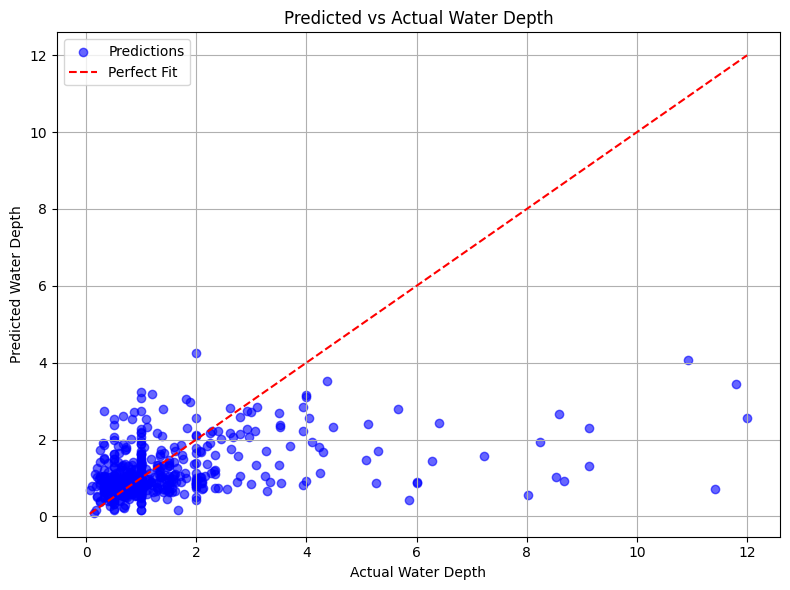

<Figure size 640x480 with 0 Axes>

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the trained model
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy().flatten()
    y_true = y_test.cpu().numpy().flatten()

# y_pred_norm and y_true_norm are normalized numpy arrays (e.g., model outputs and test targets)

y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1)).ravel()


# Compute metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Compute Pearson correlation

pearson_r, p_value = pearsonr(y_true, y_pred)

# Compute error stats
errors = y_pred - y_true
mean_error = np.mean(errors)
std_error = np.std(errors)

# Print results
print("Model Performance Statistics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"Mean Error: {mean_error:.4f}")
print(f"Std of Error: {std_error:.4f}")
print(f"Pearson r: {pearson_r:.4f} (p-value: {p_value:.4e})")

# Scatter plot
plt.figure(figsize=(8, 6))

# Use min/max across BOTH arrays to span the line

plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label='Predictions')

mn = min(np.min(y_true), np.min(y_pred))
mx = max(np.max(y_true), np.max(y_pred))

plt.plot([mn, mx], [mn, mx], color='red', linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Water Depth')
plt.ylabel('Predicted Water Depth')
plt.title('Predicted vs Actual Water Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig('predicted_vs_actual_water_depth.png', dpi=300, bbox_inches='tight')
plt.show()


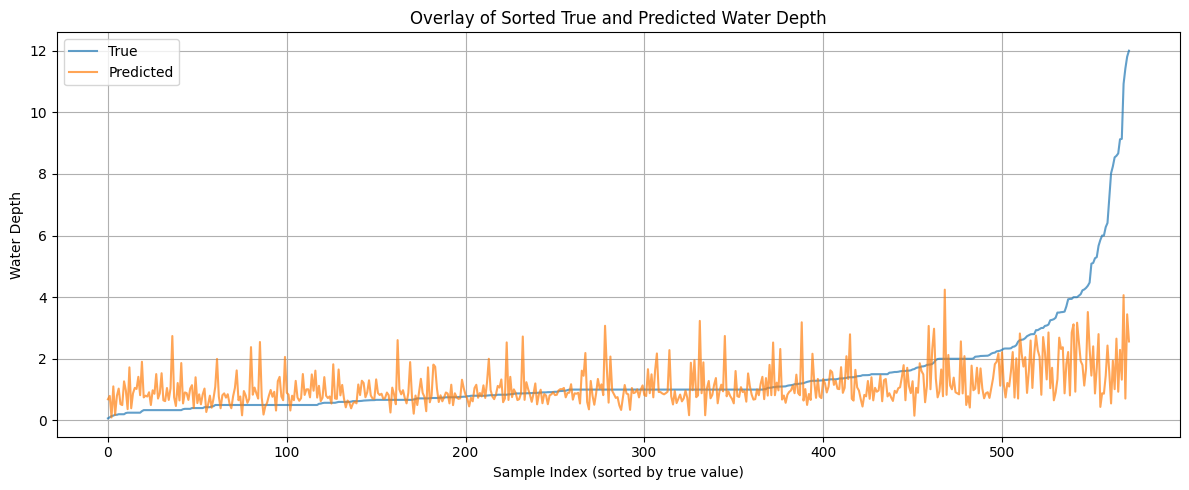

In [9]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Flatten arrays if needed
y_true_1d = y_true.ravel()
y_pred_1d = y_pred.ravel()

# Sort indices by true values
sorted_indices = np.argsort(y_true_1d)

# Sort true and predicted values accordingly
y_true_sorted = y_true_1d[sorted_indices]
y_pred_sorted = y_pred_1d[sorted_indices]

plt.figure(figsize=(12, 5))

# Plot sorted true values
pd.Series(y_true_sorted, name='True').plot(alpha=0.7)

# Plot sorted predicted values
pd.Series(y_pred_sorted, name='Predicted').plot(alpha=0.7)

plt.title('Overlay of Sorted True and Predicted Water Depth')
plt.xlabel('Sample Index (sorted by true value)')
plt.ylabel('Water Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Regression Performance:
R² Score: 0.0192
MAE: 0.8895
RMSE: 1.5495
Pearson r: [0.14729616] (p-value: [0.0004087])


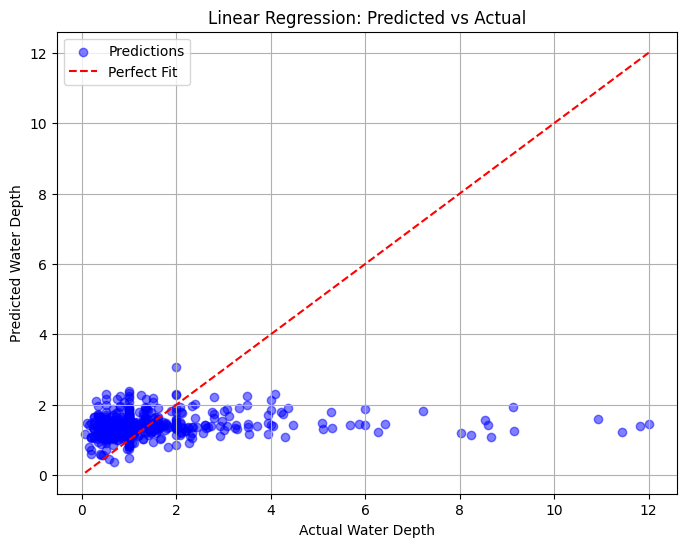

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
# 3. Train-test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

# # Features to [0, 1] (optional)
# x_scaler = StandardScaler()
# X_train_np = x_scaler.fit_transform(X_train_np)
# X_test_np  = x_scaler.transform(X_test_np)

# # Targets to [0, 1]
# y_scaler = StandardScaler()
# y_train_np = y_scaler.fit_transform(y_train_np.values.reshape(-1, 1))
# y_test_np  =  y_scaler.fit_transform(y_test_np.values.reshape(-1, 1))


# # Convert to tensors
# X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
# X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
# y_train = torch.tensor(y_train_np.reshape(-1, 1),  dtype=torch.float32).to(device)
# y_test  = torch.tensor(y_test_np.reshape(-1, 1),   dtype=torch.float32).to(device)

# Convert to tensors
X_train = torch.tensor(X_train_np.values, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np.values,  dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np.values.reshape(-1, 1),  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np.values.reshape(-1, 1),   dtype=torch.float32).to(device)

# Fit Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train.cpu().numpy(), y_train.cpu().numpy())  # Convert tensors to NumPy

# Predictions
y_pred = lin_reg.predict(X_test.cpu().numpy())

# Compute metrics
r2 = r2_score(y_test.cpu().numpy(), y_pred)
mae = mean_absolute_error(y_test.cpu().numpy(), y_pred)
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), y_pred))
pearson_r, p_value = pearsonr(y_test.cpu().numpy(), y_pred)

print("Linear Regression Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson r: {pearson_r} (p-value: {p_value})")

# Optional: Plot predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test.cpu().numpy(), y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(y_test.cpu().numpy()), max(y_test.cpu().numpy())],
         [min(y_test.cpu().numpy()), max(y_test.cpu().numpy())],
         color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Water Depth')
plt.ylabel('Predicted Water Depth')
plt.title('Linear Regression: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
pearson_r[0]

np.float32(0.14729616)

In [12]:
y_test.shape

torch.Size([572, 1])